## Data Unzip

In [1]:
import numpy as np
from torch.utils.data import DataLoader
from tqdm import tqdm
import random

import torch
import torch.nn as nn
import torchaudio
import IPython.display as ipd
import matplotlib.pyplot as plt
from pathlib import Path
import zipfile
from glob import glob

import pretty_midi
pretty_midi.pretty_midi.MAX_TICK = 1e10

torch.set_printoptions(sci_mode=False)

In [2]:
maps_path = Path('/home/dasol/userdata/onsets-and-frames/maps')

# UNZIP
maps_piano_path = list(maps_path.rglob('*_2.zip'))
# for path in maps_piano_path:
#     zipfile.ZipFile(path).extractall(maps_path)

In [3]:
def time2frame(time, sr=16000, hop_length=512):
    return round((time * sr) / hop_length)

In [4]:
class MAPSDataset:
    def __init__(self, dir_path, split, sr=16000):
        self.sr = sr
        self.hop_length = 512
        self.dir_path = list(dir_path.glob('./*/*/'))
        self.frame_per_sec =  self.sr/self.hop_length

        # split train, test set
        train_folder = ['AkPnBcht', 'AkPnBsdf', 'AkPnCGdD', 'AkPnStgb', 'SptkBGAm', 'SptkBGCl', 'StbgTGd2']
        test_folder = ['ENSTDkAm', 'ENSTDkCl']
        self.target_folder = train_folder if split=='train' else test_folder

        self._load_data()

    def get_piano_roll(self, path):
        # make label - total
        midi = pretty_midi.PrettyMIDI(midi_file=path)
        total = midi.get_piano_roll(fs=self.frame_per_sec, times=None, pedal_threshold=64)
        total[total > 0] = 1 # remove velocity
        total = total[21:109]
        # make label - onset
        onset = np.zeros_like(total)
        for note in midi.instruments[0].notes:
            onset[int(note.pitch) - 21, int(note.start * self.frame_per_sec)] = 1
        pianoroll = np.stack([total, onset], axis=0)
        return pianoroll

    def _load_data(self):
        # make lists of wav, midi paths
        self.audio = []
        self.roll = []
        for path in self.dir_path:
            folder = path.parent.name
            wav_files = list(path.rglob('*.wav'))
            missing_list = []

            if folder in self.target_folder:
                for file in wav_files:
                    midi = file.with_suffix('.mid')
                    if not midi.exists():
                        missing_list.append(id)
                        continue
                    roll = self.get_piano_roll(str(midi))
                    self.audio.append(file)
                    self.roll.append(roll)
        print(missing_list)

    def __len__(self):
        return len(self.audio)
        
    def __getitem__(self, idx):
        audio, sr = torchaudio.load(self.audio[idx])
        audio = torchaudio.functional.resample(audio, sr, self.sr)
        roll = self.roll[idx]
        start = random.randint(0, len(audio[0]) - (self.sr * 25) - 1)
        end = start + (self.sr * 20)
        sliced_audio = audio[:, start:end].mean(dim=0) # stereo to mono

        start_roll = time2frame(start/self.sr)
        end_roll = start_roll + int(20 * self.sr/512)
        sliced_roll = roll[:, :, start_roll:end_roll]

        return sliced_audio, sliced_roll

In [5]:
trainset = MAPSDataset(maps_path, 'train')
testset = MAPSDataset(maps_path, 'test')

[]
[]


In [6]:
train_loader = DataLoader(trainset, batch_size=8, shuffle=True, num_workers=0)
test_loader = DataLoader(testset, batch_size=10, num_workers=0)
batch = next(iter(train_loader))

In [7]:
batch[0].shape, batch[1].shape

(torch.Size([8, 320000]), torch.Size([8, 2, 88, 625]))

#### Label끼리 잘 맞나 확인

In [8]:
def check_label(split: str, idx, slice: int):
    if split == 'train':
        label = trainset.roll[idx]
    elif split == 'test':
        label = testset.roll[idx]
    plt.figure(figsize=(15, 7))
    plt.imshow((label[0] + label[1])[:, :slice], aspect='auto', interpolation='nearest', origin='lower')

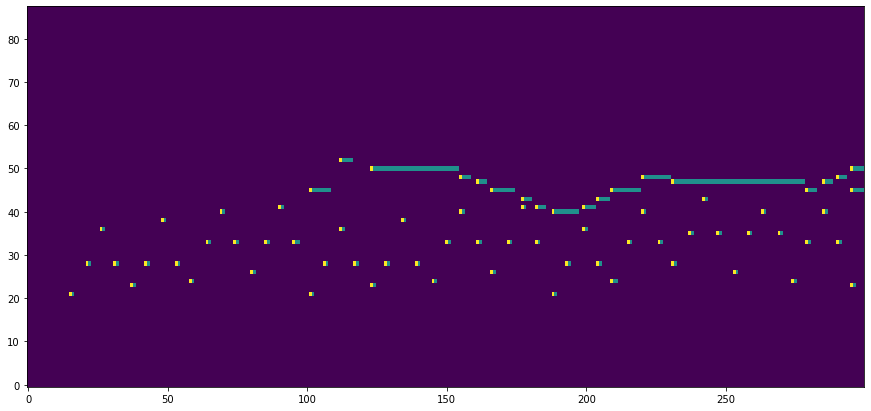

In [9]:
check_label('train', 17, 300)

#### audio-label끼리 잘 맞나 확인

In [10]:
test_audio, test_roll = trainset[77]

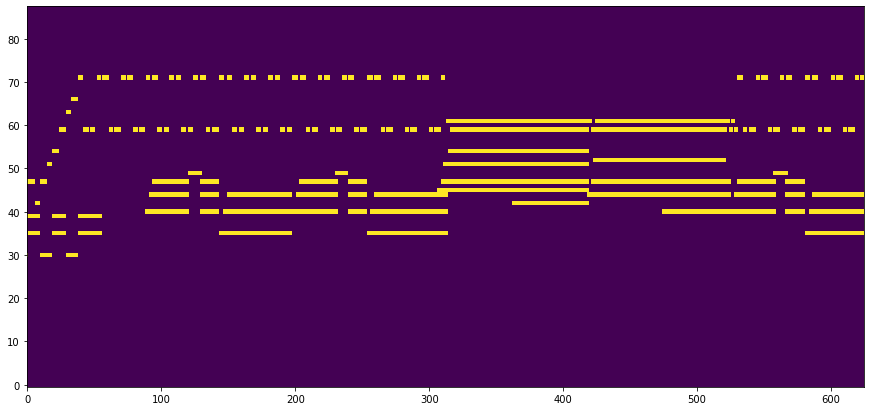

In [11]:
plt.figure(figsize=(15, 7))
plt.imshow(test_roll[0], aspect='auto', interpolation='nearest', origin='lower')

In [12]:
test_audio = test_audio.view([1, -1])
test_audio.shape

torch.Size([1, 320000])

In [13]:
torchaudio.save(filepath='/Users/idasol/Desktop/Visual_Studio_Projects/onsets_and_frames/audio_samples/sample8.wav', src= test_audio, sample_rate=16000)

## Model

In [8]:
def pitch2hz(pitch):
    return 2 ** ((pitch-69) / 12) * 440

In [25]:
mel_converter = torchaudio.transforms.MelSpectrogram(sample_rate=16000,
                                                                  n_fft = 2048,
                                                                  hop_length = 512,
                                                                  f_min = 20,
                                                                  f_max = 8000,
                                                                  n_mels = 88 * 4,
                                                            )

test_mel = mel_converter(batch[0])
test_mel = test_mel.unsqueeze(1)
test_mel.shape

torch.Size([8, 1, 352, 626])

In [32]:
class OnsetModule(nn.Module):
    def __init__(self, hidden_size=256):
        super().__init__()

        self.cnn = nn.Sequential(nn.Conv2d(1, hidden_size//4, kernel_size=(3, 3), padding=1),
                                 nn.BatchNorm2d(hidden_size//4),
                                 nn.MaxPool2d((2, 1)),
                                 nn.ReLU(),
                                 
                                 nn.Conv2d(hidden_size//4, hidden_size//2, kernel_size=(3, 3), padding=1),
                                 nn.BatchNorm2d(hidden_size//2),
                                 nn.MaxPool2d((2, 1)),
                                 nn.ReLU(),
                                 
                                 nn.Conv2d(hidden_size//2, hidden_size, kernel_size=(3, 3), padding=1),
                                 nn.BatchNorm2d(hidden_size),
                                 nn.ReLU(),)
                                 
        self.fc = nn.Linear(88 * hidden_size, hidden_size)
        self.lstm = nn.LSTM(hidden_size, hidden_size, num_layers=3, bidirectional=True, batch_first=True)
        self.projection = nn.Linear(hidden_size * 2, 88)

    def forward(self, mel_spec):
        conv_out = self.cnn(mel_spec)
        print(conv_out.shape)
        conv_out = conv_out.reshape(mel_spec.shape[0], -1, mel_spec.shape[-1])
        print(conv_out.shape)
        fc_out = self.fc(conv_out.permute(0, 2, 1))
        print(fc_out.shape)
        hidden_out, last_hidden = self.lstm(fc_out)
        logit = self.projection(hidden_out)
        prob = torch.sigmoid(logit)

        return prob.permute(0, 2, 1) # pianoroll 형식으로 변환
        

model = OnsetModule()
onset_out = model(test_mel)
onset_out.shape

torch.Size([8, 256, 88, 626])
torch.Size([8, 22528, 626])
torch.Size([8, 626, 256])


torch.Size([8, 88, 626])

In [33]:
class FrameModule(nn.Module):
    def __init__(self, hidden_size=256):
        super().__init__()

        self.cnn = nn.Sequential(nn.Conv2d(1, hidden_size//4, kernel_size=(3, 3), padding=1),
                                 nn.BatchNorm2d(hidden_size//4),
                                 nn.MaxPool2d((2, 1)),
                                 nn.ReLU(),
                                 
                                 nn.Conv2d(hidden_size//4, hidden_size//2, kernel_size=(3, 3), padding=1),
                                 nn.BatchNorm2d(hidden_size//2),
                                 nn.MaxPool2d((2, 1)),
                                 nn.ReLU(),
                                 
                                 nn.Conv2d(hidden_size//2, hidden_size, kernel_size=(3, 3), padding=1),
                                 nn.BatchNorm2d(hidden_size),
                                 nn.ReLU(),)
                                 
        self.fc = nn.Linear(88 * hidden_size, 88) 
        self.lstm = nn.LSTM(88 * 2, hidden_size, num_layers=3, bidirectional=True, batch_first=True)
        self.projection = nn.Linear(hidden_size * 2, 88)

    def forward(self, mel_spec, onset_out):
        conv_out = self.cnn(mel_spec)
        conv_out = conv_out.reshape(mel_spec.shape[0], -1, mel_spec.shape[-1])
        print(conv_out.shape)
        fc_out = self.fc(conv_out.permute(0, 2, 1))
        print(fc_out.shape)
        total_fc_out = torch.concat([onset_out.permute(0, 2, 1), fc_out], dim=2)
        print(total_fc_out.shape)
        hidden_out, last_hidden = self.lstm(total_fc_out)

        logit = self.projection(hidden_out)
        prob = torch.sigmoid(logit)
        
        return prob.permute(0, 2, 1) # pianoroll 형식으로 변환

model = FrameModule()
frame_out = model(test_mel, onset_out)
frame_out.shape

torch.Size([8, 22528, 626])
torch.Size([8, 626, 88])
torch.Size([8, 626, 176])


torch.Size([8, 88, 626])

In [35]:
class OnsetAndFrameModel(nn.Module):
    def __init__(self, hidden_size=256):
        super().__init__()
        self.mel_converter = torchaudio.transforms.MelSpectrogram(sample_rate=16000,
                                                                  n_fft = 2048,
                                                                  hop_length = 512,
                                                                  f_min = 20,
                                                                  f_max = 8000,
                                                                  n_mels = 88 * 4,
                                                            )
        self.onset_module = OnsetModule()
        self.frame_module = FrameModule()

    def forward(self, x):
        assert isinstance(x, torch.Tensor) and x.ndim == 2
        mel_spec = self.mel_converter(x) # batch size x num mels x time
        mel_spec = mel_spec.unsqueeze(1)

        onset_out = self.onset_module(mel_spec)
        frame_out = self.frame_module(mel_spec, onset_out)
        return onset_out, frame_out

model = OnsetAndFrameModel()
onset_out, frame_out = model(batch[0])

torch.Size([8, 256, 88, 626])
torch.Size([8, 22528, 626])
torch.Size([8, 626, 256])
torch.Size([8, 22528, 626])
torch.Size([8, 626, 88])
torch.Size([8, 626, 176])


## Model 2

In [8]:
SAMPLE_RATE = 16000
HOP_LENGTH = SAMPLE_RATE * 32 // 1000
MIN_MIDI = 21
MAX_MIDI = 108

N_MELS = 229
MEL_FMIN = 30
MEL_FMAX = SAMPLE_RATE // 2 
WINDOW_LENGTH = 2048

# DEFAULT_DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

cuda = torch.device('cuda')

In [9]:
class ConvStack(nn.Module):
    def __init__(self, hidden_size=256):
        super().__init__()
        self.cnn = nn.Sequential(nn.Conv2d(1, hidden_size//4, kernel_size=(3, 3), padding=1),
                                 nn.BatchNorm2d(hidden_size//4),
                                 nn.MaxPool2d((2, 1)),
                                 nn.ReLU(),
                                 
                                 nn.Conv2d(hidden_size//4, hidden_size//2, kernel_size=(3, 3), padding=1),
                                 nn.BatchNorm2d(hidden_size//2),
                                 nn.MaxPool2d((2, 1)),
                                 nn.ReLU(),
                                 
                                 nn.Conv2d(hidden_size//2, hidden_size, kernel_size=(3, 3), padding=1),
                                 nn.BatchNorm2d(hidden_size),
                                 nn.ReLU(),)
                                 
        self.fc = nn.Sequential(
            nn.Linear(88 * hidden_size, hidden_size),
            nn.Dropout(0.5)
        )

    def forward(self, mel_spec):
        out = self.cnn(mel_spec)
        out = out.reshape(mel_spec.shape[0], -1, mel_spec.shape[-1])
        out = self.fc(out.permute(0, 2, 1))
        return out

In [10]:
class BiLSTM(nn.Module):
    def __init__(self, input_features=256, hidden_size=128):
        super().__init__()
        self.rnn = nn.LSTM(input_features, hidden_size, num_layers=3, batch_first=True, bidirectional=True)

    def forward(self, x):
        out, _ = self.rnn(x)
        return out

In [17]:
mel_converter = torchaudio.transforms.MelSpectrogram(sample_rate=16000,
                                                     n_fft = 2048,
                                                     hop_length = 512,
                                                     f_min = 20,
                                                     f_max = 8000,
                                                     n_mels = 88 * 4,)

test_mel = mel_converter(batch[0])
test_mel = test_mel.unsqueeze(1)
print(test_mel.shape)

conv = ConvStack()
test = conv(test_mel)
print(test.shape)

lstm = BiLSTM()
test2 = lstm(test)

fc = nn.Linear(128*2, 88)
test3 = fc(test2)
sig = nn.Sigmoid()
test4 = sig(test3)
test4.shape

torch.Size([8, 1, 352, 626])
torch.Size([8, 626, 256])


torch.Size([8, 626, 88])

In [11]:
class OnsetandFrameModel(nn.Module):
    def __init__(self): 
        super().__init__()
        
        self.mel_converter = torchaudio.transforms.MelSpectrogram(sample_rate=16000,
                                                                  n_fft = 2048,
                                                                  hop_length = 512,
                                                                  f_min = 20,
                                                                  f_max = 8000,
                                                                  n_mels = 88 * 4)

        # sequence_model = lambda input_size, output_size: BiLSTM(input_size, output_size // 2)

        self.onset_stack = nn.Sequential(
            ConvStack(),
            BiLSTM(),
            nn.Linear(256, 88),
            nn.Sigmoid()
        )
        self.frame_stack = nn.Sequential(
            ConvStack(),
            nn.Linear(256, 88),
            nn.Sigmoid()
        )
        self.combined_stack = nn.Sequential(
            BiLSTM(176, 128), # ?
            nn.Linear(256, 88),
            nn.Sigmoid()
        )

    def forward(self, x):
        mel_spec = self.mel_converter(x).unsqueeze(1)
        onset_pred = self.onset_stack(mel_spec)
        # offset_pred = self.offset_stack(mel_spec)
        activation_pred = self.frame_stack(mel_spec)
        combined_pred = torch.cat([onset_pred.detach(), activation_pred], dim=-1)
        frame_pred = self.combined_stack(combined_pred)
        # velocity_pred = self.velocity_stack(mel_spec)
        return onset_pred.permute(0, 2, 1), activation_pred.permute(0, 2, 1), frame_pred.permute(0, 2, 1) ## ??
        

model = OnsetandFrameModel()
onset_pred, activation_pred, frame_pred = model(batch[0])

In [18]:
onset_pred.shape

torch.Size([8, 88, 626])

In [19]:
batch[1][0, 1].shape

torch.Size([88, 625])

In [14]:
def get_binary_cross_entropy_loss(pred, target, eps=1e-7):
    return -(target * torch.log(pred+eps) + (1-target) * torch.log((1-pred)+eps)).mean()

onset_loss = get_binary_cross_entropy_loss(onset_pred[..., :-1], batch[1][0, 1])
frame_loss = get_binary_cross_entropy_loss(frame_pred[..., :-1], batch[1][0, 0])

onset_loss, frame_loss

(tensor(0.6936, dtype=torch.float64, grad_fn=<NegBackward0>),
 tensor(0.6932, dtype=torch.float64, grad_fn=<NegBackward0>))

In [21]:
model = OnsetandFrameModel()
optimizer = torch.optim.Adam(model.parameters())
num_epochs = 5
loss_record = []
test_record = []
model.train()

for epoch in  tqdm(range(num_epochs)):
    for batch in tqdm(train_loader, leave=False):
        audio, roll = batch
        onset_pred, activation_pred, frame_pred = model(audio)
        onset_loss = get_binary_cross_entropy_loss(onset_pred[..., :-1], roll[0, 1])
        frame_loss = get_binary_cross_entropy_loss(frame_pred[..., :-1], roll[0, 0])
        loss = onset_loss + frame_loss
        loss.backward()

        optimizer.step()
        optimizer.zero_grad()
        loss_record.append(loss.item())

    model.eval()
    with torch.no_grad():
        epoch_loss = 0
        for batch in test_loader:
            audio, roll = batch
            onset_test_pred, activation_test_pred, frame_test_pred = model(audio)
            onset_test_loss = get_binary_cross_entropy_loss(onset_pred[..., :-1], roll[0, 1])
            frame_test_loss = get_binary_cross_entropy_loss(frame_pred[..., :-1], roll[0, 0])
            test_loss = onset_test_loss + frame_test_loss
            epoch_loss += test_loss.item()
        test_record.append(epoch_loss / len(test_loader))
    model.train()

  0%|          | 0/5 [00:00<?, ?it/s]

In [ ]:
x = [5, 6, 7, 8, 9]
y = []
for num in range(len(x)):
    convert = [(i, i) for i in range(num)]
    for j in convert[1]:
        for a in j :
            y.append(a)
y